In [4]:
import sys
sys.path.append("..")

import SimpleITK as sitk
from utils.plot import plot_volume, plot
from utils.dicom import resample, normalize_hu, read_dcm
from utils.ct import project, to_8bit, min_max_normalize
from covid_ct.dataset.body_mask import get_body_mask
from lidc.dataset.run import circle_mask
from covid_ct.metadata.parse_dcm_fields import parse_record
from covid_ct.metadata.select_dcms import check_series_consistency, check_unique, classify_images
import numpy as np
from tqdm import tqdm
import pandas as pd
import pydicom as pyd
from typing import Dict, Any
from utils.config import CONFIG
import cv2 as cv
from glob import glob

In [5]:
items = list(glob(f"{CONFIG.CXR2018_DIR}/train/NORMAL/*.jpeg"))
print(len(items))

1349


In [4]:
pd.read_pickle("/workspace/output/lidc/test/metadata.pkl").iloc[[154, 128, 80]]["subject"].tolist()

IndexError: positional indexers are out-of-bounds

In [20]:
vol = normalize_hu(read_dcm(items[79])[1])
circle_mask(vol)
# plot_volume(vol)

ImageSeriesReader (0x55d2fde800b0): Non uniform sampling or missing slices detected,  maximum nonuniformity:291.747



array([], shape=(0, 440, 440), dtype=uint8)

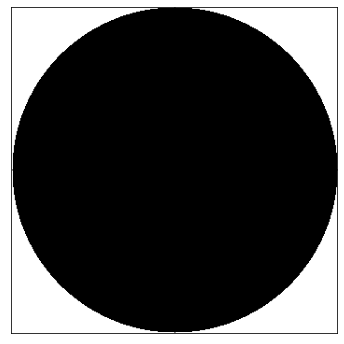

In [3]:
N = 350
circle = np.zeros((N,N))
center = N // 2

for i in range(N):
    for j in range(N):
        if ((i - center) ** 2 + (j - center) ** 2) > (N // 2 - 1
        ) ** 2:
            circle[i][j] = 1

plot([circle])

interactive(children=(IntSlider(value=1, description='val', max=306), Output()), _dom_classes=('widget-interac…

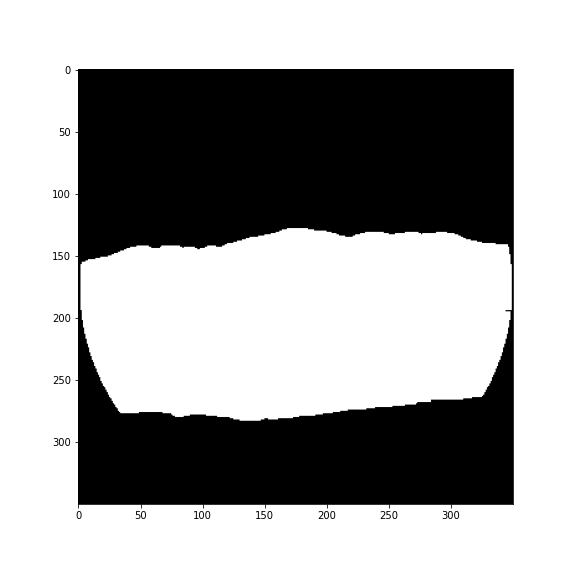

In [14]:
%matplotlib widget
masks = [get_body_mask(np.where(circle, 0, normalize_hu(img)), 30)[0] for img in vol]
plot_volume(masks)

In [5]:
df[df["Subject"] == 966].sort_values(by="Path")

,Subject,ID,Path,PhotometricInterpretation,SliceLocation,SliceThickness,ImagePositionPatient0,ImagePositionPatient1,ImagePositionPatient2,PatientPosition,ImageOrientationPatient,SeriesDescription,SeriesNumber,PixelSpacing0,PixelSpacing1,ImageType0,ImageType1,ImageType2,ImageType3,HighBit
120344,966,1-001,/data/lidc/manifest-1600709154662/LIDC-IDRI/LI...,MONOCHROME2,7.420000,2.5,-179.699997,-175.0,7.420000,FFS,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",NaN,3000280.0,0.683594,0.683594,ORIGINAL,PRIMARY,AXIAL,NONE,15
120401,966,1-002,/data/lidc/manifest-1600709154662/LIDC-IDRI/LI...,MONOCHROME2,5.420000,2.5,-179.699997,-175.0,5.420000,FFS,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",NaN,3000280.0,0.683594,0.683594,ORIGINAL,PRIMARY,AXIAL,NONE,15
120374,966,1-003,/data/lidc/manifest-1600709154662/LIDC-IDRI/LI...,MONOCHROME2,3.420000,2.5,-179.699997,-175.0,3.420000,FFS,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",NaN,3000280.0,0.683594,0.683594,ORIGINAL,PRIMARY,AXIAL,NONE,15
120323,966,1-004,/data/lidc/manifest-1600709154662/LIDC-IDRI/LI...,MONOCHROME2,1.420000,2.5,-179.699997,-175.0,1.420000,FFS,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",NaN,3000280.0,0.683594,0.683594,ORIGINAL,PRIMARY,AXIAL,NONE,15
120386,966,1-005,/data/lidc/manifest-1600709154662/LIDC-IDRI/LI...,MONOCHROME2,-0.580000,2.5,-179.699997,-175.0,-0.580000,FFS,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",NaN,3000280.0,0.683594,0.683594,ORIGINAL,PRIMARY,AXIAL,NONE,15
120294,966,1-006,/data/lidc/manifest-1600709154662/LIDC-IDRI/LI...,MONOCHROME2,-2.580000,2.5,-179.699997,-175.0,-2.580000,FFS,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",NaN,3000280.0,0.683594,0.683594,ORIGINAL,PRIMARY,AXIAL,NONE,15
120370,966,1-007,/data/lidc/manifest-1600709154662/LIDC-IDRI/LI...,MONOCHROME2,-4.580000,2.5,-179.699997,-175.0,-4.580000,FFS,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",NaN,3000280.0,0.683594,0.683594,ORIGINAL,PRIMARY,AXIAL,NONE,15
120396,966,1-008,/data/lidc/manifest-1600709154662/LIDC-IDRI/LI...,MONOCHROME2,-6.580000,2.5,-179.699997,-175.0,-6.580000,FFS,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",NaN,3000280.0,0.683594,0.683594,ORIGINAL,PRIMARY,AXIAL,NONE,15
120424,966,1-009,/data/lidc/manifest-1600709154662/LIDC-IDRI/LI...,MONOCHROME2,-8.580000,2.5,-179.699997,-175.0,-8.580000,FFS,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",NaN,3000280.0,0.683594,0.683594,ORIGINAL,PRIMARY,AXIAL,NONE,15
120420,966,1-010,/data/lidc/manifest-1600709154662/LIDC-IDRI/LI...,MONOCHROME2,-10.580000,2.5,-179.699997,-175.0,-10.580000,FFS,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",NaN,3000280.0,0.683594,0.683594,ORIGINAL,PRIMARY,AXIAL,NONE,15


In [10]:
df_count = df.groupby(["Subject", "SeriesNumber"]).count()
df_count[df_count["Path"] < 100]

,,ID,Path,PhotometricInterpretation,SliceLocation,SliceThickness,ImagePositionPatient0,ImagePositionPatient1,ImagePositionPatient2,PatientPosition,ImageOrientationPatient,SeriesDescription,PixelSpacing0,PixelSpacing1,ImageType0,ImageType1,ImageType2,ImageType3,HighBit
Subject,SeriesNumber,,,,,,,,,,,,,,,,,,
365,5409.0,98,98,98,98,98,98,98,98,98,98,0,98,98,98,98,98,98,98


In [59]:
df[df["Subject"] == 678]

,Subject,ID,Path,PhotometricInterpretation,SliceLocation,SliceThickness,ImagePositionPatient0,ImagePositionPatient1,ImagePositionPatient2,PatientPosition,ImageOrientationPatient,SeriesDescription,SeriesNumber,PixelSpacing0,PixelSpacing1,ImageType0,ImageType1,ImageType2,ImageType3,HighBit
70346,678,1-010,/data/lidc/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0678/01-01-2000-NA-NA-72850/3000016.000000-NA-10450/1-010.dcm,MONOCHROME2,9.6,2.5,-149.0,-135.0,9.6,FFS,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]",NaN,3000016.0,0.527344,0.527344,ORIGINAL,PRIMARY,AXIAL,NONE,15
